# Classifying Fashion-MNIST ( Multiclass )

We'd be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of the network, and a better representation of datasets you'll use in the real world.

In this notebook, we'll build a neural network using PyTorch framework. 

First off, let's load the dataset through torchvision.

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 40960/26421880 [00:00<01:11, 367490.91it/s]

26427392it [00:00, 76492499.41it/s]                            


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


32768it [00:00, 452485.84it/s]
  2%|▏         | 98304/4422102 [00:00<00:04, 919428.65it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


4423680it [00:00, 20832945.46it/s]                            
8192it [00:00, 164747.50it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


Here we can see one of the images. The following are utility functions

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

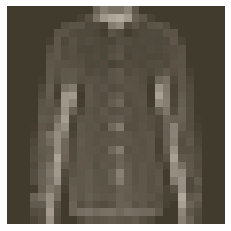

In [3]:
image, label = next(iter(trainloader))
imshow(image[0,:]);

## Building the network

As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. 

2 Hidden Layers are used with RelU activations for the layers and to return the logits or log-softmax from the forward pass. 

In [4]:
#check tensor size 
#64 images and 784 features that are flattened
image.view(64, -1).shape

torch.Size([64, 784])

In [0]:
# TODO: Define your network architecture here
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    # Defining the layers : 256, 128, 64 each
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    # Output layer, 10 classes
    self.fc4 = nn.Linear(64, 10)

  def forward(self,x):
    ''' Forward pass through the network, returns the output logits '''
    #ensure the image is flattened
    x = x.view(x.shape[0], -1)
    # Apply ReLu activation for all layers except for LogSoftmax for the output
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x),dim=1)

    return x

# Train the network

CrossEntropyLoss and Adam Optimization are used
https://gombru.github.io/2018/05/23/cross_entropy_loss/

Basically,

* We will make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [0]:
# TODO: Create the network, define the criterion and optimizer

model = Classifier()

# Define the loss
criterion = nn.NLLLoss()

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# TODO: Train the network here

EPOCHS = 50

for epoch in range(EPOCHS):
  running_loss = 0
  # Train all the images , Forward pass, then backward pass, then update weights
  for images, labels in trainloader:
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    
    # Clear the gradients, do this because gradients are accumulated
    optimizer.zero_grad()
    loss.backward()
    # Performs a parameter update based on the current gradient
    optimizer.step()
    # Update weights
    running_loss += loss.item()
  else:
    print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.5194597618221474
Training loss: 0.37774019386531954
Training loss: 0.3364722140943572
Training loss: 0.3112931296165818
Training loss: 0.29159777201632703
Training loss: 0.2763667010676378
Training loss: 0.26506000783429473
Training loss: 0.25191031869794767
Training loss: 0.23990132587789093
Training loss: 0.22860112561504725
Training loss: 0.22064562730475276
Training loss: 0.21118609434855518
Training loss: 0.20572035958660817
Training loss: 0.19462665031030615
Training loss: 0.1859349768076624
Training loss: 0.17899913663890507
Training loss: 0.17048118790504393
Training loss: 0.16708828649743757
Training loss: 0.1571082736867895
Training loss: 0.1542219133900681
Training loss: 0.14879498017161513
Training loss: 0.14364464784156222
Training loss: 0.1411117925139855
Training loss: 0.1336150592697391
Training loss: 0.1269697187774217
Training loss: 0.12328044562114042
Training loss: 0.11948423399212661
Training loss: 0.11680802240717544
Training loss: 0.1110569214922

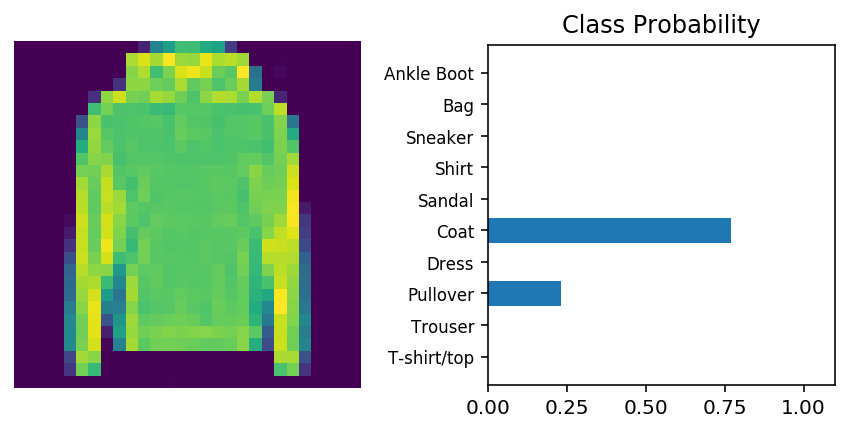

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Test out our network with the rest variable

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    ps = torch.exp(model(img))
 
# Plot the image and probabilities
view_classify(img.resize_(1, 28, 28), ps, version='Fashion')